<a href="https://colab.research.google.com/github/mahapara2411/Sentiment-Analysis/blob/master/Pareto_NBD_Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lifetimes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 584 kB 6.2 MB/s 


In [2]:
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import altair as alt
import plotly.express as px
import xlrd
import pandas as pd
import warnings
from sklearn.metrics import classification_report,confusion_matrix
import lifetimes
import dill as pickle
from sklearn.cluster import KMeans
from lifetimes import ParetoNBDFitter, GammaGammaFitter
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import plot_history_alive
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from sklearn.metrics import mean_squared_error, r2_score
import math
from math import sqrt
warnings.filterwarnings("ignore")
import datetime
np.random.seed(42)

In [3]:
data = pd.read_excel("Retail_cleaned_dataset.xlsx")

In [4]:
data["TotalPrice"] = data["Quantity"]*data["Price"]
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate']).dt.date

In [5]:
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2019-12-01,6.95,13085,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2019-12-01,6.75,13085,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2019-12-01,6.75,13085,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2019-12-01,2.10,13085,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2019-12-01,1.25,13085,United Kingdom,30.0


In [6]:
from lifetimes.plotting import *
from lifetimes.utils import *

rfm_summary = summary_data_from_transaction_data(data, 'CustomerID', 'InvoiceDate', 
                                               monetary_value_col='TotalPrice', 
                                               observation_period_end='2021-12-9')

In [7]:
rfm_summary.reset_index(inplace = True)

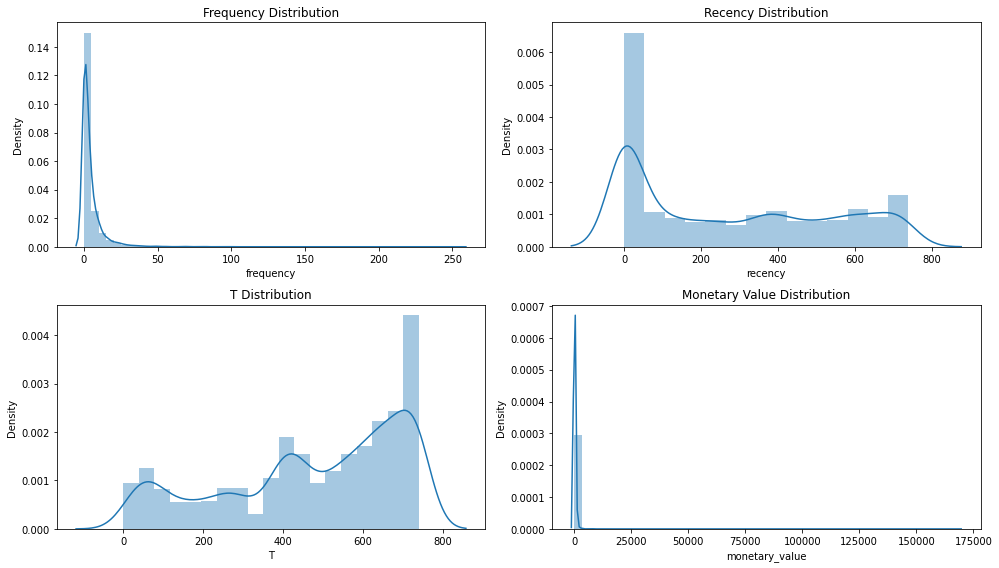

In [8]:
#plotting the distribution
plt.figure(figsize=(14,8))
plt.subplot(221)
sns.distplot(rfm_summary["frequency"])
plt.title("Frequency Distribution")
plt.subplot(222)
sns.distplot(rfm_summary["recency"])
plt.title("Recency Distribution")
plt.subplot(223)
sns.distplot(rfm_summary["T"])
plt.title("T Distribution")
plt.subplot(224)
sns.distplot(rfm_summary["monetary_value"])
plt.title("Monetary Value Distribution")
plt.tight_layout()

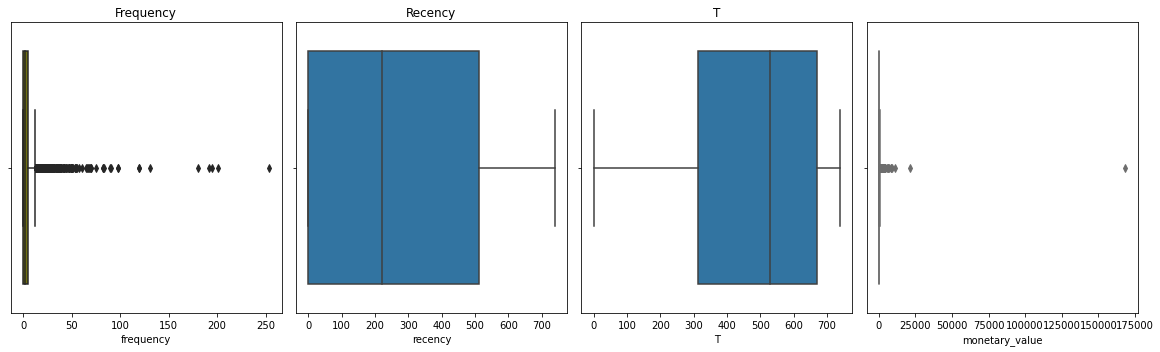

In [9]:
plt.figure(figsize=(16,5))
plt.subplot(141)
sns.boxplot(rfm_summary["frequency"], color = "olive")
plt.title("Frequency")
plt.subplot(142)
sns.boxplot(rfm_summary["recency"])
plt.title("Recency")
plt.subplot(143)
sns.boxplot(rfm_summary["T"])
plt.title("T")
plt.subplot(144)
sns.boxplot(rfm_summary["monetary_value"], color = "salmon")

plt.tight_layout()

In [10]:
rfm_summary.describe(percentiles = [0.01,0.1,0.25,0.50,0.75,0.90,0.99])

,CustomerID,frequency,recency,T,monetary_value
count,5878.000000,5878.000000,5878.000000,5878.000000,5878.000000
mean,15315.313542,4.632358,273.647669,474.551718,312.996561
std,1715.572666,9.999783,259.242435,223.394778,2255.743170
min,12346.000000,0.000000,0.000000,0.000000,0.000000
1%,12405.770000,0.000000,0.000000,15.000000,0.000000
10%,12936.700000,0.000000,0.000000,89.000000,0.000000
25%,13833.250000,0.000000,0.000000,313.000000,0.000000
50%,15314.500000,2.000000,221.000000,530.000000,207.117500
75%,16797.750000,5.000000,512.000000,669.000000,368.045909
90%,17696.300000,11.000000,668.000000,731.000000,591.139417


In [11]:
rfm_summary.head()

,CustomerID,frequency,recency,T,monetary_value
0,12346,7.0,401.0,726.0,11066.637143
1,12347,7.0,402.0,404.0,615.714286
2,12348,4.0,363.0,438.0,449.310000
3,12349,3.0,571.0,589.0,1120.056667
4,12350,0.0,0.0,310.0,0.000000


**Pareto/NBD Model**

In [12]:
def get_model(data, penalizer_val, time):
    
    pareto_result = data.copy()

    pareto_model = ParetoNBDFitter(penalizer_coef = penalizer_val)
    pareto_model.fit(pareto_result["frequency"], pareto_result["recency"], pareto_result["T"])

    #calculating the predicted_purchases

    t = time

    pareto_result["predicted_purchases"] = pareto_model.conditional_expected_number_of_purchases_up_to_time(t, pareto_result["frequency"], pareto_result["recency"], pareto_result["T"])


    pareto_result["Actual_Purchases"] = pareto_result["frequency"]/pareto_result["recency"]*time

    #filling the null values
    pareto_result["Actual_Purchases"].fillna(0, inplace = True)


    #calculating the error
    pareto_result["Prediction_Error"] = pareto_result["Actual_Purchases"]-pareto_result["predicted_purchases"]

    #calcuating the purchase prediction error
    pareto_mse_purchase = mean_squared_error(pareto_result["Actual_Purchases"], pareto_result["predicted_purchases"])
    pareto_r2_purchase = r2_score(pareto_result["Actual_Purchases"], pareto_result["predicted_purchases"])
    pareto_rmse_purchase = sqrt(mean_squared_error(pareto_result["Actual_Purchases"], pareto_result["predicted_purchases"]))
    pareto_avg_error_purchase = pareto_result["Prediction_Error"].mean()
    
    #printing the purchase prediction error
    print("Predicted Purchase Mean Squared Error: %s" %(pareto_mse_purchase))
    print("Predicted Purchase R2 Score: %s" %(pareto_r2_purchase))
    print("Predicted Purchase Root Mean Squared Error: %s" %(pareto_rmse_purchase))
    print("Predicted Purchase Average Purchases Error: %s" %(pareto_avg_error_purchase))
    
    
    #plotting the prediction v/s actual purchase plot
    plt.figure(figsize=(6,4))
    plt.errorbar(pareto_result["Actual_Purchases"], pareto_result["predicted_purchases"], yerr=pareto_result["Prediction_Error"], fmt='o', color='darkseagreen',
                 ecolor='grey', elinewidth=1.5, capsize=0, alpha = 0.2);
    plt.title("Prediction v/s Actual")

Predicted Purchase Mean Squared Error: 2.2178054572100874
Predicted Purchase R2 Score: 0.060510353555273455
Predicted Purchase Root Mean Squared Error: 1.4892298201453285
Predicted Purchase Average Purchases Error: 0.23184043664196166


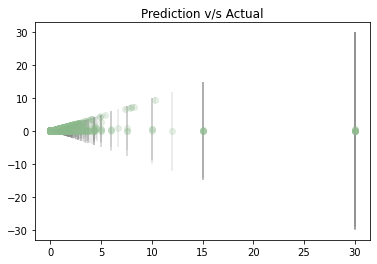

In [13]:
get_model(rfm_summary, 0.001, 30)

In [14]:
pareto_model = lifetimes.ParetoNBDFitter(penalizer_coef = 0.1)

In [15]:
pareto_model.fit(rfm_summary["frequency"],rfm_summary["recency"],
                rfm_summary["T"])
print(pareto_model)

<lifetimes.ParetoNBDFitter: fitted with 5878 subjects, alpha: 72.03, beta: 385.66, r: 0.74, s: 0.18>

In [ ]:
pareto_model.summary

**Frequency-Recency Matrix**

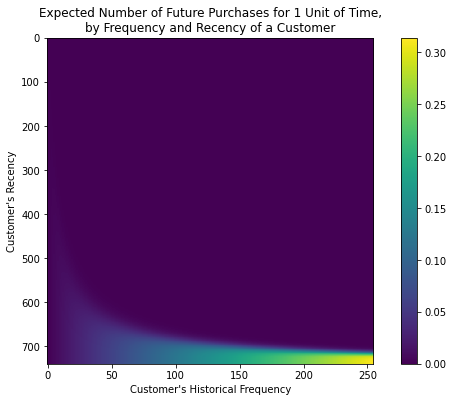

In [16]:
plt.figure(figsize=(10,6))
plot_frequency_recency_matrix(pareto_model)

**Churn/Active Probability**

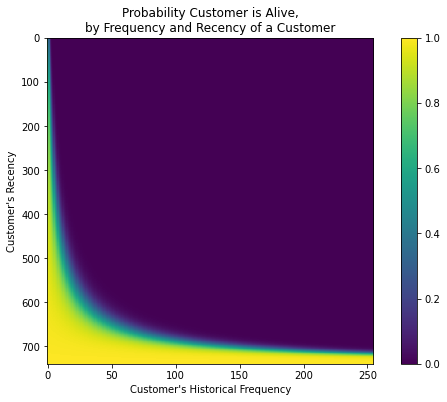

In [17]:
plt.figure(figsize=(10,6))
plot_probability_alive_matrix(pareto_model)

In [18]:
#pareto_result = rfm_summary.copy()

In [19]:
rfm_summary["p_not_alive"] = 1-pareto_model.conditional_probability_alive(rfm_summary["frequency"], rfm_summary["recency"], rfm_summary["T"])
rfm_summary["p_alive"] = pareto_model.conditional_probability_alive(rfm_summary["frequency"], rfm_summary["recency"], rfm_summary["T"])

In [20]:
rfm_summary.head()

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive
0,12346,7.0,401.0,726.0,11066.637143,0.465187,0.534813
1,12347,7.0,402.0,404.0,615.714286,0.000467,0.999533
2,12348,4.0,363.0,438.0,449.310000,0.025307,0.974693
3,12349,3.0,571.0,589.0,1120.056667,0.003551,0.996449
4,12350,0.0,0.0,310.0,0.000000,0.167712,0.832288


**Predict future transaction number**

In [21]:
t = 1 # in the next 1 day
rfm_summary["predicted_purchases"] = pareto_model.conditional_expected_number_of_purchases_up_to_time(t, rfm_summary["frequency"], rfm_summary["recency"], rfm_summary["T"])

In [22]:
# Highest 5 customers
rfm_summary.sort_values(by='predicted_purchases').tail(5)

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases
0,12346,7.0,401.0,726.0,11066.637143,0.465187,0.534813,0.155209
1,12347,7.0,402.0,404.0,615.714286,0.000467,0.999533,0.485818
2,12348,4.0,363.0,438.0,449.310000,0.025307,0.974693,0.270791
3,12349,3.0,571.0,589.0,1120.056667,0.003551,0.996449,0.168606
4,12350,0.0,0.0,310.0,0.000000,0.167712,0.832288,0.048093
...,...,...,...,...,...,...,...,...
5873,18283,18.0,656.0,659.0,142.666667,0.000541,0.999459,0.766602
5874,18284,0.0,0.0,431.0,0.000000,0.222904,0.777096,0.034122
5875,18285,0.0,0.0,661.0,0.000000,0.309941,0.690059,0.020808
5876,18286,1.0,248.0,724.0,833.480000,0.201957,0.798043,0.052165


In [ ]:
# Lowest 5 customers
rfm_summary.sort_values(by='predicted_purchases').head(5)

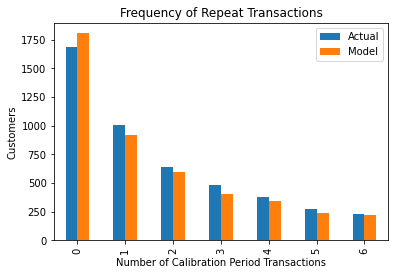

In [23]:
plot_period_transactions(pareto_model)

**Model validation: split calibration and holdout sets**

In [24]:
#dividing our dataset into training & holdout
pareto_summary_cal_holdout = calibration_and_holdout_data(data, "CustomerID", "InvoiceDate", 
                                                   calibration_period_end = '2021-08-31',
                                                  observation_period_end = '2021-12-09')

In [25]:
pareto_summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12346,7.0,401.0,626.0,0.0,100.0
12347,5.0,275.0,304.0,2.0,100.0
12348,3.0,190.0,338.0,1.0,100.0
12349,2.0,182.0,489.0,1.0,100.0
12350,0.0,0.0,210.0,0.0,100.0


In [26]:
pareto_model.fit(pareto_summary_cal_holdout["frequency_cal"],
               pareto_summary_cal_holdout["recency_cal"],
               pareto_summary_cal_holdout["T_cal"])

<lifetimes.ParetoNBDFitter: fitted with 5249 subjects, alpha: 74.57, beta: 1807.17, r: 0.73, s: 0.98>

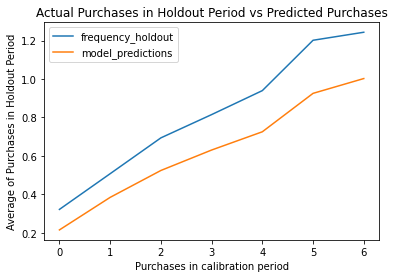

In [27]:
plot_calibration_purchases_vs_holdout_purchases(pareto_model, pareto_summary_cal_holdout)

In [28]:
pareto_summary_cal_holdout['predicted_purchases'] = pareto_model.conditional_expected_number_of_purchases_up_to_time(100,pareto_summary_cal_holdout["frequency_cal"],pareto_summary_cal_holdout["recency_cal"],pareto_summary_cal_holdout["T_cal"])

In [29]:
pareto_summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout,predicted_purchases
CustomerID,,,,,,
12346,7.0,401.0,626.0,0.0,100.0,0.204892
12347,5.0,275.0,304.0,2.0,100.0,0.443448
12348,3.0,190.0,338.0,1.0,100.0,0.228649
12349,2.0,182.0,489.0,1.0,100.0,0.097029
12350,0.0,0.0,210.0,0.0,100.0,0.065125


In [30]:
from sklearn.metrics import mean_squared_error, r2_score

def smape(y_true, y_pred):
    difference = abs(y_true - y_pred)
    denominator = (abs(y_true) + abs(y_pred))/2
    return np.mean(np.where(denominator==0, 0, difference/denominator))

In [31]:
print('RMSE: ', mean_squared_error(pareto_summary_cal_holdout['frequency_holdout'], pareto_summary_cal_holdout['predicted_purchases'])**(1/2))
print('SMAPE', smape(pareto_summary_cal_holdout['frequency_holdout'], pareto_summary_cal_holdout['predicted_purchases']))
print('R2: ', r2_score(pareto_summary_cal_holdout['frequency_holdout'], pareto_summary_cal_holdout['predicted_purchases']))

RMSE:  1.9267435276373452
SMAPE 1.7381538149767979
R2:  0.1289704401767806


In [ ]:
# predict for a specific customer, number of purchase in next 10 days
t = 10
individual = rfm_summary.loc[12380]
pareto_model.predict(t, individual['frequency'], individual['recency'], individual['T'])

In [32]:
#pareto_result["actual30"] = pareto_result["frequency"]/pareto_result["recency"]*30

In [33]:
#pareto_result["actual30"].fillna(0, inplace = True)

In [34]:
#pareto_result["error"] = pareto_result["actual30"]-pareto_result["predicted_purchases"]

In [35]:
#pareto_result.head()

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual30,error
0,12346,7.0,401.0,726.0,11066.637143,0.465187,0.534813,0.155209,0.523691,0.368482
1,12347,7.0,402.0,404.0,615.714286,0.000467,0.999533,0.485818,0.522388,0.036570
2,12348,4.0,363.0,438.0,449.310000,0.025307,0.974693,0.270791,0.330579,0.059788
3,12349,3.0,571.0,589.0,1120.056667,0.003551,0.996449,0.168606,0.157618,-0.010988
4,12350,0.0,0.0,310.0,0.000000,0.167712,0.832288,0.048093,0.000000,-0.048093


**Historical probability of being alive**

In [ ]:
data = data[~data.index.duplicated()]

In [ ]:
# Customer 14606
# frequent customer, alive throughout the year.
id = 14606
days_since_birth = 365
sp_trans = data.loc[data['CustomerID'] == id]
plot_history_alive(pareto_model, days_since_birth, sp_trans, 'InvoiceDate')

In [36]:
#Get the history alive plot to check whether the customer is alive or not

def get_history_alive(t_, data_, id_):
    
    individual_alive = data[data["CustomerID"] == id_]
    plot_history_alive(pareto_model, t = t_, transactions = individual_alive, datetime_col = "InvoiceDate",
                  freq = "D")

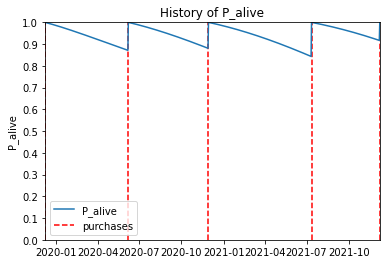

In [37]:
get_history_alive(30, data, 12358.0)

**GAMMA-GAMMA MODEL**

In [38]:
returning_customers_summary = rfm_summary[rfm_summary['frequency']>0]

In [ ]:
# 64% customer left
len(returning_customers_summary)/len(rfm_summary)

In [39]:
returning_customers_summary = returning_customers_summary.index

In [40]:
ggf_filter = rfm_summary.drop(returning_customers_summary, axis = 0)

In [41]:
m_idx = ggf_filter[(ggf_filter["monetary_value"] <= 0.0)].index

In [42]:
ggf_filter = ggf_filter.drop(m_idx, axis = 0)

In [43]:
ggf_filter.reset_index().drop("index", axis = 1, inplace = True)

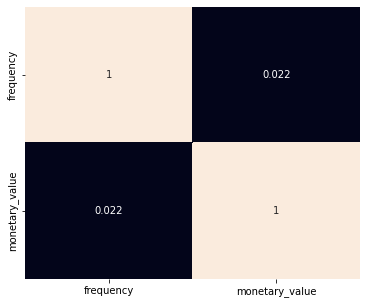

In [44]:
plt.figure(figsize=(6,5))
sns.heatmap(ggf_filter[["frequency", "monetary_value"]].corr(), annot = True, cbar = False)

In [45]:
ggf_model =  lifetimes.GammaGammaFitter(penalizer_coef=0.1)

In [46]:
ggf_model.fit(ggf_filter["frequency"], ggf_filter["monetary_value"])

<lifetimes.GammaGammaFitter: fitted with 4189 subjects, p: 1.02, q: 0.18, v: 0.93>

In [47]:
ggf_model.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,1.019926,0.024531,0.971846,1.068006
q,0.179152,0.002996,0.173280,0.185023
v,0.933467,0.025489,0.883508,0.983426


In [48]:
ggf_filter["expected_avg_sales_"] = ggf_model.conditional_expected_average_profit(ggf_filter["frequency"],
                                                                                     ggf_filter["monetary_value"])

In [49]:
ggf_filter.head()

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual30,error,expected_avg_sales_
0,12346,7.0,401.0,726.0,11066.637143,0.465187,0.534813,0.155209,0.523691,0.368482,12504.444869
1,12347,7.0,402.0,404.0,615.714286,0.000467,0.999533,0.485818,0.522388,0.036570,695.851861
2,12348,4.0,363.0,438.0,449.310000,0.025307,0.974693,0.270791,0.330579,0.059788,562.775388
3,12349,3.0,571.0,589.0,1120.056667,0.003551,0.996449,0.168606,0.157618,-0.010988,1531.122915
6,12352,8.0,356.0,392.0,338.261250,0.012357,0.987643,0.556060,0.674157,0.118098,376.226899


In [50]:
print("Mean Squared Error: %s" %(mean_squared_error(ggf_filter["monetary_value"], ggf_filter["expected_avg_sales_"])))
print("Root Mean Squared Error: %s" %(sqrt(mean_squared_error(ggf_filter["monetary_value"], ggf_filter["expected_avg_sales_"]))))
print("R2 Score: %s" %(r2_score(ggf_filter["monetary_value"], ggf_filter["expected_avg_sales_"])))

Mean Squared Error: 118447363.6217067
Root Mean Squared Error: 10883.352591077195
R2 Score: -15.721908585813079


In [51]:
ggf_filter["predicted_clv"] = ggf_model.customer_lifetime_value(pareto_model,
                                                       ggf_filter["frequency"],
                                                       ggf_filter["recency"],
                                                       ggf_filter["T"],
                                                       ggf_filter["monetary_value"],
                                                       time = 30,
                                                       freq = 'D',
                                                       discount_rate = 0.01)

In [52]:
#Top 5 customers with high CLV
ggf_filter[["CustomerID", "predicted_clv"]].sort_values(by = "predicted_clv", ascending = False).head(5)

,CustomerID,predicted_clv
4061,16446,3.465014e+06
5692,18102,4.876255e+05
2277,14646,4.382067e+05
189,12536,3.429485e+05
5050,17450,2.767094e+05


In [53]:
# Assuming 5% of Profit Margin
ggf_filter["profit_margin"] = ggf_filter["predicted_clv"]*0.05

In [54]:
ggf_filter.reset_index().drop("index", axis = 1, inplace = True)

In [55]:
#exporting the result to csv
ggf_filter.to_csv("customer_lifetime_value_prediction.csv")

**CUSTOMER SEGMENTATION USING PREDICTED CLV**

In [56]:
ggf_filter.head()

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual30,error,expected_avg_sales_,predicted_clv,profit_margin
0,12346,7.0,401.0,726.0,11066.637143,0.465187,0.534813,0.155209,0.523691,0.368482,12504.444869,28461.287397,1423.064370
1,12347,7.0,402.0,404.0,615.714286,0.000467,0.999533,0.485818,0.522388,0.036570,695.851861,7380.367658,369.018383
2,12348,4.0,363.0,438.0,449.310000,0.025307,0.974693,0.270791,0.330579,0.059788,562.775388,3257.802368,162.890118
3,12349,3.0,571.0,589.0,1120.056667,0.003551,0.996449,0.168606,0.157618,-0.010988,1531.122915,5677.407696,283.870385
6,12352,8.0,356.0,392.0,338.261250,0.012357,0.987643,0.556060,0.674157,0.118098,376.226899,4516.299703,225.814985


In [57]:
col = ["predicted_purchases", "expected_avg_sales_", "predicted_clv", "profit_margin"]

In [59]:
new_df = ggf_filter[col]
print(new_df)

      predicted_purchases  expected_avg_sales_  predicted_clv  profit_margin
0                0.155209         12504.444869   28461.287397    1423.064370
1                0.485818           695.851861    7380.367658     369.018383
2                0.270791           562.775388    3257.802368     162.890118
3                0.168606          1531.122915    5677.407696     283.870385
6                0.556060           376.226899    4516.299703     225.814985
...                   ...                  ...            ...            ...
5871             0.076241           418.843596     668.173098      33.408655
5872             0.261352           403.576306    2236.024625     111.801231
5873             0.766602           149.398389    2541.316718     127.065836
5876             0.052165          4274.910277    4093.101205     204.655060
5877             0.264345           741.876901    4280.270736     214.013537

[4189 rows x 4 columns]


In [60]:
inertia = []

for i in range(1, 11):
    kmeans  = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(new_df)
    inertia.append(kmeans.inertia_)

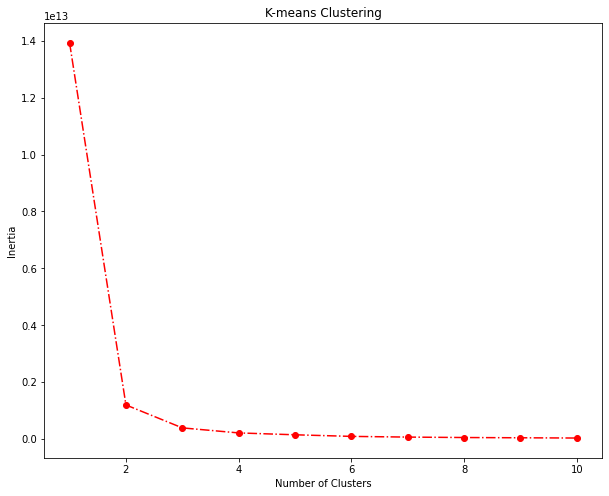

In [61]:
plt.figure(figsize = (10,8))
plt.plot(range(1, 11), inertia, marker = 'o', linestyle = '-.',color='red')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('K-means Clustering')
plt.show()

In [68]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)

In [69]:
labels=kmeans.fit(new_df)

In [70]:
df_segm_kmeans= new_df.copy()
new_df['Segment K-means'] = kmeans.labels_

In [71]:
df_segm_analysis = new_df.groupby(['Segment K-means']).mean()
df_segm_analysis

,predicted_purchases,expected_avg_sales_,predicted_clv,profit_margin
Segment K-means,,,,
0,0.324033,758.436149,3.883884e+03,194.194200
1,0.187433,863116.959561,3.465014e+06,173250.722234
2,3.103728,22851.858246,3.188418e+05,15942.089200
3,2.046050,4194.432976,7.652610e+04,3826.305192


In [72]:
df_segm_analysis.rename({0:'Low',
                         1:'High',
                         2:'Very High',
                         3:'Medium'})

,predicted_purchases,expected_avg_sales_,predicted_clv,profit_margin
Segment K-means,,,,
Low,0.324033,758.436149,3.883884e+03,194.194200
High,0.187433,863116.959561,3.465014e+06,173250.722234
Very High,3.103728,22851.858246,3.188418e+05,15942.089200
Medium,2.046050,4194.432976,7.652610e+04,3826.305192


In [73]:
# Add the segment labels to our table
df_segm_kmeans['Labels'] = df_segm_kmeans['Segment K-means'].map({0:'Low',
                                                                  1:'High',
                                                                  2:'Very High',
                                                                  3:'Medium'})

In [74]:
df_segm_kmeans.head()

,predicted_purchases,expected_avg_sales_,predicted_clv,profit_margin,Segment K-means,Labels
0,0.155209,12504.444869,28461.287397,1423.064370,0,Low
1,0.485818,695.851861,7380.367658,369.018383,0,Low
2,0.270791,562.775388,3257.802368,162.890118,0,Low
3,0.168606,1531.122915,5677.407696,283.870385,0,Low
6,0.556060,376.226899,4516.299703,225.814985,0,Low


In [75]:
ggf_filter = pd.concat([ggf_filter,df_segm_kmeans['Segment K-means'],df_segm_kmeans['Labels']], axis = 1)

In [76]:
ggf_filter.head()

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual30,error,expected_avg_sales_,predicted_clv,profit_margin,Segment K-means,Labels
0,12346,7.0,401.0,726.0,11066.637143,0.465187,0.534813,0.155209,0.523691,0.368482,12504.444869,28461.287397,1423.064370,0,Low
1,12347,7.0,402.0,404.0,615.714286,0.000467,0.999533,0.485818,0.522388,0.036570,695.851861,7380.367658,369.018383,0,Low
2,12348,4.0,363.0,438.0,449.310000,0.025307,0.974693,0.270791,0.330579,0.059788,562.775388,3257.802368,162.890118,0,Low
3,12349,3.0,571.0,589.0,1120.056667,0.003551,0.996449,0.168606,0.157618,-0.010988,1531.122915,5677.407696,283.870385,0,Low
6,12352,8.0,356.0,392.0,338.261250,0.012357,0.987643,0.556060,0.674157,0.118098,376.226899,4516.299703,225.814985,0,Low


In [77]:
ggf_filter.groupby('Labels').CustomerID.count()/ggf_filter.CustomerID.count()*100

Labels
High          0.023872
Low          98.925758
Medium        0.859394
Very High     0.190976
Name: CustomerID, dtype: float64

In [78]:
ggf_filter.to_csv("Segmentation_result.csv")

In [79]:
data.InvoiceDate

0         2019-12-01
1         2019-12-01
2         2019-12-01
3         2019-12-01
4         2019-12-01
             ...    
779423    2021-12-09
779424    2021-12-09
779425    2021-12-09
779426    2021-12-09
779427    2021-12-09
Name: InvoiceDate, Length: 779428, dtype: object

In [80]:
import datetime

dfnew_train = data[data.InvoiceDate <= datetime.date(2021, 8, 31)]
dfnew_test = data[data.InvoiceDate > datetime.date(2021, 8, 31)]

maxdate = dfnew_train.InvoiceDate.max()
mindate = dfnew_train.InvoiceDate.min()

dfnew_train['duration'] =  (maxdate - dfnew_train.InvoiceDate)/np.timedelta64(1, 'D')
# get time duration between the last transaction to now
dfsum1 = dfnew_train.groupby(['CustomerID'])['duration'].min().reset_index()
dfsum1.rename(columns = {'duration':'latetime'}, inplace = True)

# get time duration between the first transaction to now
dfsum2 = dfnew_train.groupby(['CustomerID'])['duration'].max().reset_index()
dfsum2.rename(columns = {'duration':'earlytime'}, inplace = True)

# get transaction frequency (whole history)
dfsum3 = dfnew_train.groupby(['CustomerID'])['InvoiceDate'].nunique().reset_index()
dfsum3.rename(columns={'InvoiceDate': 'freq'}, inplace=True)
# get transaction frequency (recent 3 months history)
dfsum4 = dfnew_train[dfnew_train.duration<91].groupby(['CustomerID'])['InvoiceDate'].nunique().reset_index()
dfsum4.rename(columns={'InvoiceDate': 'freq_3m'}, inplace=True)

dfsum = pd.merge(dfsum1, dfsum2, on=['CustomerID'], how='outer')
dfsum = pd.merge(dfsum, dfsum3, on=['CustomerID'], how='outer')
dfsum = pd.merge(dfsum, dfsum4, on=['CustomerID'], how='outer')

# get target: number of transactions in test set
dfsum_target = dfnew_test.groupby(['CustomerID'])['InvoiceDate'].nunique().reset_index()
dfsum_target.rename(columns={'InvoiceDate': 'target'}, inplace=True)
dfsum = pd.merge(dfsum, dfsum_target, on=['CustomerID'], how='left')
dfsum  = dfsum.fillna(0).sort_values(['target'], ascending = False)

In [81]:
dfsum['target'].describe()

count    5249.000000
mean        1.011431
std         2.064661
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        52.000000
Name: target, dtype: float64

In [82]:
dfsum.head(10)

,CustomerID,latetime,earlytime,freq,freq_3m,target
2258,14911,5.0,639.0,203,33.0,52.0
344,12748,1.0,636.0,159,29.0,43.0
4850,17841,3.0,638.0,154,29.0,39.0
2618,15311,12.0,639.0,168,20.0,28.0
1985,14606,3.0,637.0,157,19.0,24.0
538,12971,7.0,625.0,78,17.0,21.0
646,13089,0.0,638.0,113,13.0,19.0
194,12569,7.0,152.0,10,6.0,16.0
1576,14156,14.0,639.0,105,13.0,16.0
1264,13798,7.0,632.0,83,9.0,16.0


**XG Boost Model**

In [83]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

xgb_model = xgb.XGBRegressor(n_estimators=2200, objective='reg:linear', max_depth = 3)
 
predictors = ['latetime','earlytime', 'freq','freq_3m']
X = dfsum[predictors]
y = dfsum.target

x_trains, x_valids, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=12)

xgb_model.fit(x_trains, y_train)

[08:00:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=2200)

In [84]:
y_pred = xgb_model.predict(x_valids)
rmse = mean_squared_error(y_valid, y_pred)**(1/2)
print('RMSE on test set: ', rmse)

RMSE on test set:  1.4864709479717237


In [85]:
xgb_model2 = xgb.XGBRegressor(n_estimators=2200, objective='reg:linear', max_depth = 3)
xgb_model2.fit(X, y)
y_pred2 = xgb_model2.predict(X)
print('RMSE: ', mean_squared_error(y, y_pred2)**(1/2))
print('SMAPE', smape(y, y_pred2))
print('R2: ', r2_score(y, y_pred2))

[08:00:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE:  0.7462622540130873
SMAPE 1.3236862334247157
R2:  0.8693323660313689


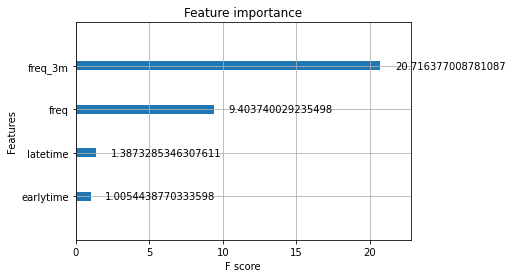

In [86]:
xgb.plot_importance(xgb_model, importance_type='gain')

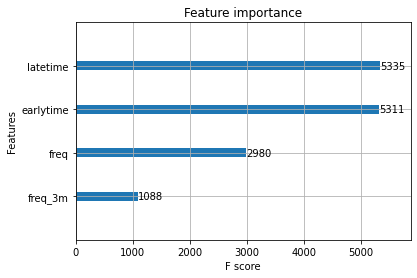

In [87]:
xgb.plot_importance(xgb_model, importance_type='weight')

In [88]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [89]:
est = RandomForestClassifier(n_jobs=-1)
rf_p_dist={'max_depth':[3,5,10,None],
              'n_estimators':[10,100,200,300,400,500],
              'max_features':randint(1,3),
               'criterion':['gini','entropy'],
               'bootstrap':[True,False],
               'min_samples_leaf':randint(1,4),
              }
def hypertuning_rscv(est, p_distr, nbr_iter,X,y):
    rdmsearch = RandomizedSearchCV(est, param_distributions=p_distr,
                                  n_jobs=-1, n_iter=nbr_iter, cv=9)
    #CV = Cross-Validation ( here using Stratified KFold CV)
    rdmsearch.fit(X,y)
    ht_params = rdmsearch.best_params_
    ht_score = rdmsearch.best_score_
    return ht_params, ht_score

rf_parameters, rf_ht_score = hypertuning_rscv(est, rf_p_dist, 40, X, y)

In [90]:
print(rf_parameters)

{'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'max_features': 1, 'min_samples_leaf': 3, 'n_estimators': 300}


In [92]:
clasifier=RandomForestClassifier(bootstrap= False, criterion= 'gini', max_depth= None, max_features= 1, min_samples_leaf= 1, n_estimators= 200)

clasifier.fit(x_trains,y_valid)

ValueError: ignored

In [ ]:
y_pred = clasifier.predict(x_valids)

In [ ]:
from sklearn.metrics import confusion_matrix,accuracy_score
cm = confusion_matrix(y_valid, y_pred)

accuracy_score=accuracy_score(y_valid,y_pred)

In [ ]:
accuracy_score